# The following file contains: 

- LDA
- Topic Modeling
- TF-IDF/Bag of Words with Polynomial Model - And predictions 
- Similarity Scores between bin role job descriptions (aggregated)

In [1]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import nltk
import re
import spacy
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora
import pickle
import gensim
import pyLDAvis.gensim
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import glob
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from nltk.probability import FreqDist

import json
import pytesseract
import glob

import re
from PIL import Image

from pytesseract import image_to_string

In [2]:
df = pd.read_csv('../data_processed/concatenated_data_cleaned_labeled_preprocessed_alt.csv') 

### LDA With Gensim
As seen on: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

list of tokens -> bag-of-words corpus -> dictionary -> bag-of-words corpus -> LDA model



from LDA model -> extract top topics

Documentation of Gensim

https://radimrehurek.com/gensim/models/ldamodel.html

### Preprocessing for LDA

In [3]:
'''Fixing desc_tokens column'''
#df_test = df.iloc[0:10, :]


desc_tokens = list(df['new_description'])

new_col = []
for i, item in enumerate(desc_tokens):
    listed = list(item.split())
    new_col.append(listed)

df['desc_tokens'] = new_col

desc_tokens = list(df['desc_tokens'])
desc_tokens[0:2]

[['noom',
  'scientifically',
  'proven',
  'method',
  'help',
  'user',
  'create',
  'healthier',
  'lifestyle',
  'manage',
  'important',
  'condition',
  'like',
  'ii',
  'diabetes',
  'obesity',
  'hypertension',
  'engineering',
  'team',
  'forefront',
  'challenge',
  'solving',
  'complex',
  'technical',
  'problem',
  'center',
  'around',
  'habit',
  'behavior',
  'lifestyle',
  'looking',
  'data',
  'engineer',
  'join',
  'data',
  'team',
  'help',
  'u',
  'improve',
  'maintain',
  'data',
  'warehouse',
  'like',
  'billion',
  'row',
  'data',
  'center',
  'data',
  'driven',
  'decision',
  'love',
  'like',
  'u',
  'problem',
  'affect',
  'life',
  'real',
  'people',
  'user',
  'depend',
  'u',
  'make',
  'positive',
  'change',
  'health',
  'life',
  'base',
  'scientifically',
  'proven',
  'peer',
  'reviewed',
  'methodology',
  'designed',
  'medical',
  'professionalswe',
  'respectful',
  'diverse',
  'dynamic',
  'environment',
  'engineering',


### Creating a dictionary from aggregated data descriptions. 

In [4]:
# Create a dictionary from the data
dictionary = corpora.Dictionary(desc_tokens)

# Create a bag-of-words corpus 
# also called corpus! 

doc_term_matrix = [dictionary.doc2bow(text) for text in desc_tokens]
# print(len(doc_term_matrix))
# print(doc_term_matrix[0:2])

In [7]:
# pickle.dump(doc_term_matrix, open('doc_term_matrix.pkl', 'wb'))
#dictionary.save('dictionary.gensim')

### Preprocessing of Descriptions Grouped by Bin Roles

In [5]:
by_role = df.groupby('bin_role')

'''Creates a dictionary called by_role_tokens where an aggregated list of tokens is saved for each bin role
NOTE: that desc_tokens should be a list of lists - one list of words per document'''

by_role_tokens = {}

for key, item in by_role:
    aggregated_tokens = []
    print(key)
    #print(item['desc_tokens'])
    desc_tokens = list(item['desc_tokens'])

    #for item2 in item['desc_tokens']:
        #aggregated_tokens = aggregated_tokens + item2
    by_role_tokens[key] = desc_tokens

Business Analyst
Data Analyst
Data Engineer
Data Scientist
ML/AI Researcher
Machine Learning Engineer
Software Engineer
Statistical Modeler/Researcher
Unclassified


## Topic modeling for each bin_role group

### Question --> Can we use the same dictionary for each subject/bin role subject analysis? Or should we create new models for each role? 

In [175]:
# Top 3 subjects/topics for each bin_role grouping

NUM_TOPICS = 3

for key, values in by_role_tokens.items():
    
    doc_term_matrix = [dictionary.doc2bow(text) for text in values]
    
    ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

    topics = ldamodel.print_topics(num_words=4)
    print(key)
    for topic in topics:
        print(topic)
    print()

Business Analyst
(0, '0.026*"business" + 0.012*"project" + 0.011*"process" + 0.010*"system"')
(1, '0.028*"business" + 0.023*"data" + 0.011*"team" + 0.007*"reporting"')
(2, '0.018*"data" + 0.011*"business" + 0.009*"management" + 0.009*"system"')

Data Analyst
(0, '0.037*"data" + 0.012*"business" + 0.008*"team" + 0.008*"analysis"')
(1, '0.022*"data" + 0.006*"analysis" + 0.006*"position" + 0.006*"preferred"')
(2, '0.031*"data" + 0.006*"analytics" + 0.006*"team" + 0.006*"process"')

Data Engineer
(0, '0.036*"u" + 0.016*"data" + 0.010*"learning" + 0.010*"team"')
(1, '0.033*"data" + 0.008*"cloud" + 0.008*"technology" + 0.008*"team"')
(2, '0.051*"data" + 0.009*"business" + 0.008*"team" + 0.006*"design"')

Data Scientist
(0, '0.025*"data" + 0.007*"team" + 0.007*"business" + 0.006*"model"')
(1, '0.038*"data" + 0.010*"science" + 0.009*"learning" + 0.009*"business"')
(2, '0.029*"data" + 0.014*"business" + 0.009*"science" + 0.008*"learning"')

ML/AI Researcher
(0, '0.028*"learning" + 0.024*"machin

### Same as above but with new dictionaries for each bin role

In [12]:
# Top 3 subjects/topics for each bin_role grouping

NUM_TOPICS = 3

for key, values in by_role_tokens.items():
    
    # Create a dictionary from the data
    dictionary = corpora.Dictionary(values)
    
    doc_term_matrix = [dictionary.doc2bow(text) for text in values]
    
    ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

    topics = ldamodel.print_topics(num_words=4)
    print(key)
    for topic in topics:
        print(topic)
    print()

Business Analyst
(0, '0.017*"business" + 0.009*"data" + 0.009*"analysis" + 0.008*"service"')
(1, '0.029*"data" + 0.020*"business" + 0.010*"team" + 0.008*"reporting"')
(2, '0.034*"business" + 0.014*"process" + 0.012*"project" + 0.012*"system"')

Data Analyst
(0, '0.030*"data" + 0.010*"business" + 0.007*"analytics" + 0.006*"analysis"')
(1, '0.041*"data" + 0.013*"business" + 0.009*"team" + 0.007*"analyst"')
(2, '0.035*"data" + 0.009*"analysis" + 0.009*"team" + 0.007*"analyst"')

Data Engineer
(0, '0.056*"data" + 0.009*"team" + 0.008*"system" + 0.007*"business"')
(1, '0.033*"u" + 0.027*"data" + 0.011*"team" + 0.010*"learning"')
(2, '0.032*"data" + 0.009*"cloud" + 0.009*"technology" + 0.009*"solution"')

Data Scientist
(0, '0.042*"data" + 0.012*"business" + 0.009*"science" + 0.008*"learning"')
(1, '0.028*"data" + 0.010*"team" + 0.007*"statistical" + 0.006*"business"')
(2, '0.029*"data" + 0.011*"learning" + 0.011*"science" + 0.009*"business"')

ML/AI Researcher
(0, '0.020*"learning" + 0.017*

# pyLDAvis

Establishes most salient terms and creates distance plot maps of words

In [107]:
ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics = 3, id2word=dictionary, passes=15)

#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
#lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/ckato/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Text Classification Model
### Using Multinomial Naive Bayes Classification from scikit-learn

As seen on: 
https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk

The following model uses the one-hot-encoded description column in the data frame as the set of X features and evaluates the bin role as the response (y variable). 

## 1. Using TF-IDF


In [7]:
def group_descriptions(by_role):
    '''Creates concatenated/joined text for job descriptions for each bin role'''
    roles = []
    merged_desc = []
    for key, items in by_role.indices.items():
        # concatenate strings in descriptions column (by search_role grouping) and append to list of merged descriptions
        string=(" ").join(description for description in df.loc[items,'new_description'])
        merged_desc.append(string)
        roles.append(key)

    return merged_desc, roles

In [8]:
'''descriptions variable is list of concatenated descriptions separated by bin role'''
descriptions, roles = group_descriptions(by_role)

In [198]:
# generate matrix of word vectors 

tf=TfidfVectorizer()
text_tf= tf.fit_transform(df['new_description'])

# Build the training and sets using the one-hot-encoded TF-IDF vectorizer
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, df['bin_role'], test_size=0.10, random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.5596846846846847


## 2. Using Bag of Words


In [12]:
# You can generate document term matrix by using scikit-learn's CountVectorizer.
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [69]:
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['new_description'])


X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['bin_role'], test_size=0.3, random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))






MultinomialNB Accuracy: 0.8209459459459459


In [13]:
# for trigram model - change ngram_range

cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (3,3),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['new_description'])

X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['bin_role'], test_size=0.3, random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.8543543543543544


## Predictions Using Classification Model with Job Descriptions (from real life?)
Reference: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [71]:
clf # trigram model from above

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [220]:
print(df.iloc[0,:])

df.loc[0, 'description']

bin_role                                               Data Engineer
company                                                    Noom Inc.
description         At Noom, we use scientifically proven methods...
location                                                New York, NY
title                                                 Data Engineer 
url                https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
desc_tokens        [noom, scientifically, proven, method, help, u...
new_description    noom scientifically proven method help user cr...
Name: 0, dtype: object


' At Noom, we use scientifically proven methods to help our users create healthier lifestyles, and manage important conditions like Type-II Diabetes, Obesity, and Hypertension. Our Engineering team is at the forefront of this challenge, solving complex technical problems that center around habits, behavior, and lifestyle. We are looking for a Data Engineer to join our Data team and help us improve and maintain our Data Warehouse. If you like to work with billions of rows of data and be at the center of data-driven decisions, we’ll love working with you. What You’ll Like About Us We work on problems that affect the lives of real people. Our users depend on us to make positive changes to their health and their lives.We base our work on scientifically-proven, peer-reviewed methodologies that are designed by medical professionalsWe’re a respectful, diverse, and dynamic environment in which Engineering is a first-class citizen, and where you’ll be able to work on a variety of interesting pr

### Try predicting label for first row, using job description printed above

In [216]:
test_description = 'At Noom, we use scientifically proven methods to help our users create healthier lifestyles, and manage important conditions like Type-II Diabetes, Obesity, and Hypertension. Our Engineering team is at the forefront of this challenge, solving complex technical problems that center around habits, behavior, and lifestyle. We are looking for a Data Engineer to join our Data team and help us improve and maintain our Data Warehouse. If you like to work with billions of rows of data and be at the center of data-driven decisions, we’ll love working with you. What You’ll Like About Us We work on problems that affect the lives of real people. Our users depend on us to make positive changes to their health and their lives.We base our work on scientifically-proven, peer-reviewed methodologies that are designed by medical professionalsWe’re a respectful, diverse, and dynamic environment in which Engineering is a first-class citizen, and where you’ll be able to work on a variety of interesting problems that affect the lives of real people.We offer a generous budget for personal development expenses like training courses, conferences, and books.You’ll get three weeks’ paid vacation and a flexible work policy that is remote- and family-friendly (about 50% of our engineering team is fully remote). We worry about results, not time spent in seats.Delicious (and nutritious) daily lunches and snacks prepared by Sam, our NYC office on-site chef. What We’ll Like About You You have experience dealing with data at scale, processing and transforming hundreds of millions of data points per day.You have first-rate SQL skills, but you are aware of its limits. You know when to use it, and when it’s better to find a different solution.You are familiar with ETL tools and problems. We use Airflow, Redshift, Glue, and many other systems.You’re used to work alongside data analysts and data scientists to help them prepare complex datasets that can be used to solve difficult problems. Job Type: Full-time'

print('Predicted Role Label: ', clf.predict(cv.transform([test_description])))

Predicted Role Label:  ['Data Engineer']


In [219]:
print(df.iloc[1,:])
df.loc[1, 'description']


bin_role                                              Data Scientist
company                                Strategic Financial Solutions
description         Overview\nDo you love numbers and finding the...
location                                          New York, NY 10018
title                                           Lead Data Scientist 
url                https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
desc_tokens        [love, number, finding, story, number, thought...
new_description    love number finding story number thought tackl...
Name: 1, dtype: object


' Overview\nDo you love numbers and finding the story in the numbers? Does the thought of tackling a complex data issue make you smile? Have you got a knack for solving problems? Do you want to help drive the results of a multi-million dollar business? If you have answered “yes” to these questions, the Lead Data Scientist position at Strategic Financial Solutions may be the right fit for you. Strategic is looking for an experienced Data Science leader with extensive machine learning experience to join our Data Science Team, which already produces cutting-edge models for predictive and prescriptive analytics. The person in this role would be responsible for leading a focused team conducting data analysis and developing predictive models leveraging data science and machine learning to solve various business use cases, including marketing intelligence, customer segmentation, and predictive models for operations. We are looking for a Data Scientist who will support our product, sales, lead

### Try predicting label using job description printed above

In [72]:
test_description = 'creating algorithms and creating/running simulations. They must have a proven ability to drive business results with their data-based insights. They must be comfortable working with a wide range of stakeholders and functional teams. The right candidate will have a passion for discovering solutions hidden in large data sets and working with stakeholders to improve business outcomes. Responsibilities\nWork with stakeholders to identify opportunities for leveraging company data to drive business analytics solutions.\nResearch and develop statistical learning models for data analysis\nCommunicate results and ideas to key decision makers\nIdentify valuable data sources and automate collection processes\nUndertake preprocessing of structured and unstructured data\nAnalyze large amounts of information to discover trends and patterns\nBuild predictive models and machine-learning algorithms\nPresent information using data visualization techniques\nCollaborate with sales, marketing and senior executive teams\nQualifications\n~5-8 years of relevant experience\nGraduate degree in Statistics, Data Science, Applied Math, Operations Research, or Computer Science.\nStrong problem-solving skills with an emphasis on sales and marketing predictive analytics.\nExperience using statistical computer languages (R, Python, SQL, etc.) to manipulate data and draw insights from large data sets.\nKnowledge of a variety of machine learning techniques (clustering, decision tree learning, artificial neural networks, etc.) and their real-world advantages/drawbacks.\nKnowledge and experience in statistical and data mining techniques: GLM/Regression, Random Forest, Boosting, Trees, text mining, social network analysis, etc.\nKnowledge of advanced statistical techniques and concepts (regression, properties of distributions, statistical tests and proper usage, etc.) and experience with applications.\nExcellent written and verbal communication skills for coordinating across teams.\nA drive to learn and master new technologies and techniques.\nExperience using business intelligence tools (e.g. PowerBI, Tableau) and data frameworks (e.g. Hadoop)\nAbout Strategic:\nStrategic Financial Solutions is a leading consumer finance company that specializes in helping people that have too much credit card debt. We were recently named the 21st Best Company to Work for in New York by Best Companies to Work For and have been certified as a Great Place to Work 4 times. Additional honors include being named, two times, as one of the 50 fastest growing companies in New York City and to the prestigious Inc. 500 list as one of the 500 fastest growing companies in the United States.'

print('Predicted Role Label: ', clf.predict(cv.transform([test_description])))



Predicted Role Label:  ['Data Scientist']


## Resume Uploader / Scanner / Role Predictor
NOTE: 
- For image to text to work, resume must have white background, black lettering
- Resume must also be in png or jpg format (not pdf)

In [6]:
def img_to_text(image_location):
    img = Image.open('../data_processed/' + image_location)

    text=pytesseract.image_to_string(img)
    print(text)
    return text

In [8]:
# Example

filename = 'resume_test.png'
chiemi_resume_string = img_to_text(filename)

CHIEMI

Data Scient

PROFILE:

In the past few years, | have built up my
credibility on one simple principle: Work
smarter, not harder. | have a hunger for
learning new technologies and | strive to
boost the productivity of everyone
around.

-Pythen: NumPy, SciPy, Matplotib, Pandas,
Scikit-Learn, Keras, Tensorflow, NLTK, Seaborn
-R: Dplyr, MASS, Boot, Class, glmnet, Caret,
randomForest, ROCR, ggplot

- Linear Regression, Logistic Regression,
KNN, Ridge, Lasso, SVM, Decision Trees,
Random Forests, Neural Networks, Cluster
Analysis,

- Statistical Analysis, Web Scraping, Natural
Language Processing, Time Series Analysis,
Classification, Regression, Topic Modeling,
ross-Validation

KATO

st

EDUCATION

San Francisco State University

Class of 2019, GPA: 3.99

Bachelor of Science in Applied Mathematics | Graduating Fall 2019

Related coursework: Categorical Data Analysis, Statistical Learning & Data Mining, SAS
Programming, Advanced Python, Numerical Analysis, Data Structures and Algorithm

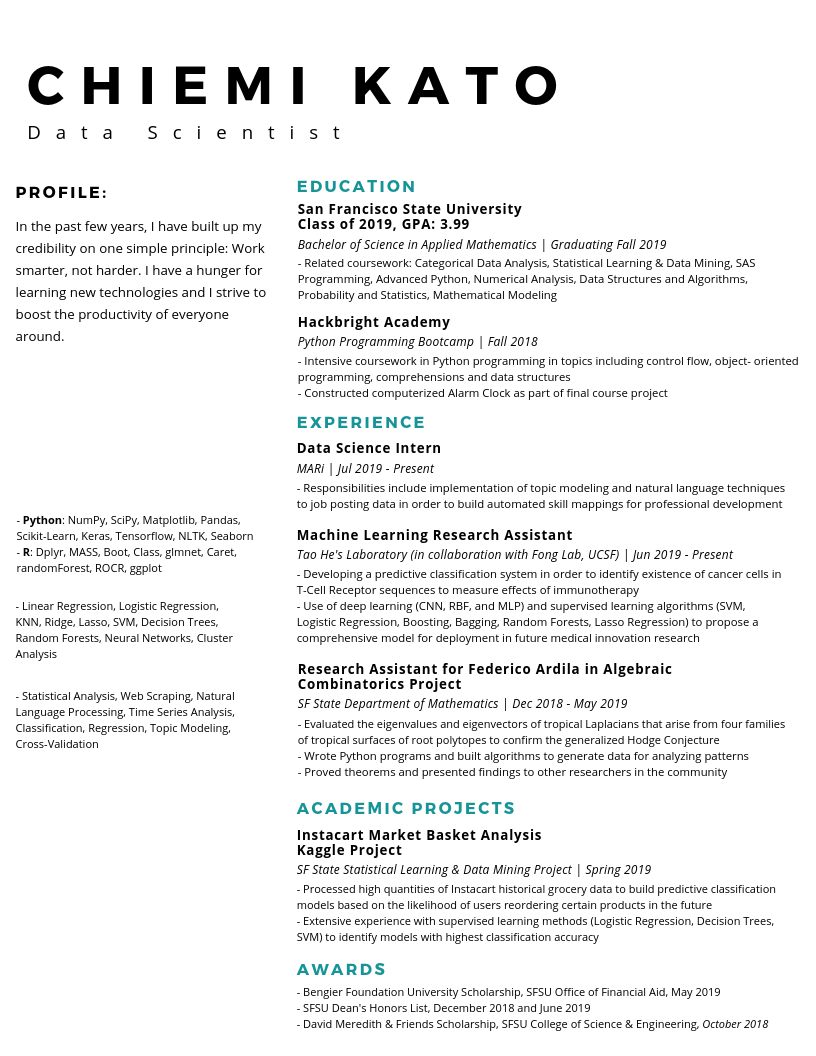

In [9]:
# Actual file view
img = Image.open('../data_processed/resume_test.png')
img

In [14]:
print('Predicted Role Label: ', clf.predict(cv.transform([chiemi_resume_string])))


Predicted Role Label:  ['Data Scientist']


# Word Similarity Between Aggregated Posts Grouped by Search Role
- Uses Cosine Similarity score

As seen on:
https://www.datacamp.com/courses/feature-engineering-for-nlp-in-python

## Similarity Score by Doc

In [38]:
# Calculating document similarities is similar but it takes the averages of the 
# word vectors of all the words in a particular document

desc_dict = dict(zip(roles, descriptions))

nlp = spacy.load('en_core_web_lg')
nlp.max_length = 93621305

counter = 1

for key, value in desc_dict.items():
    string = 'sent' + str(counter)
    vars()[string] = nlp(value)
    counter += 1



In [60]:

print('Business Analyst Job Descriptions:')
print(roles[0] ,'roles compared to', roles[1], 'roles:', sent1.similarity(sent2))
print(roles[0] ,'roles compared to', roles[2], 'roles:', sent1.similarity(sent3))
print(roles[0] ,'roles compared to', roles[3], 'roles:', sent1.similarity(sent4))
print(roles[0] ,'roles compared to', roles[4], 'roles:', sent1.similarity(sent5))
print(roles[0] ,'roles compared to', roles[5], 'roles:', sent1.similarity(sent6))
print(roles[0] ,'roles compared to', roles[6], 'roles:', sent1.similarity(sent7))
print(roles[0] ,'roles compared to', roles[7], 'roles:', sent1.similarity(sent8))
print(roles[0] ,'roles compared to', roles[8], 'roles:', sent1.similarity(sent9))
print()

print('Data Analyst Job Descriptions:')
print(roles[1] ,'roles compared to', roles[0], 'roles:', sent2.similarity(sent1))
print(roles[1] ,'roles compared to', roles[2], 'roles:', sent2.similarity(sent3))
print(roles[1] ,'roles compared to', roles[3], 'roles:', sent2.similarity(sent4))
print(roles[1] ,'roles compared to', roles[4], 'roles:', sent2.similarity(sent5))
print(roles[1] ,'roles compared to', roles[5], 'roles:', sent2.similarity(sent6))
print(roles[1] ,'roles compared to', roles[6], 'roles:', sent2.similarity(sent7))
print(roles[1] ,'roles compared to', roles[7], 'roles:', sent2.similarity(sent8))
print(roles[1] ,'roles compared to', roles[8], 'roles:', sent2.similarity(sent9))
print()


print('Data Engineer Job Descriptions:')
print(roles[2] ,'roles compared to', roles[0], 'roles:', sent3.similarity(sent1))
print(roles[2] ,'roles compared to', roles[1], 'roles:', sent3.similarity(sent2))
print(roles[2] ,'roles compared to', roles[3], 'roles:', sent3.similarity(sent4))
print(roles[2] ,'roles compared to', roles[4], 'roles:', sent3.similarity(sent5))
print(roles[2] ,'roles compared to', roles[5], 'roles:', sent3.similarity(sent6))
print(roles[2] ,'roles compared to', roles[6], 'roles:', sent3.similarity(sent7))
print(roles[2] ,'roles compared to', roles[7], 'roles:', sent3.similarity(sent8))
print(roles[2] ,'roles compared to', roles[8], 'roles:', sent3.similarity(sent9))
print()

Business Analyst Job Descriptions:
Business Analyst roles compared to Data Analyst roles: 0.9970681735863456
Business Analyst roles compared to Data Engineer roles: 0.9894188184378562
Business Analyst roles compared to Data Scientist roles: 0.9914079038051417
Business Analyst roles compared to ML/AI Researcher roles: 0.9865671710409213
Business Analyst roles compared to Machine Learning Engineer roles: 0.981864409777382
Business Analyst roles compared to Software Engineer roles: 0.9883108854383434
Business Analyst roles compared to Statistical Modeler/Researcher roles: 0.9873505187364636
Business Analyst roles compared to Unclassified roles: 0.9962424740297069

Data Analyst Job Descriptions:
Data Analyst roles compared to Business Analyst roles: 0.9970681735863456
Data Analyst roles compared to Data Engineer roles: 0.9924634142865806
Data Analyst roles compared to Data Scientist roles: 0.9962845570525684
Data Analyst roles compared to ML/AI Researcher roles: 0.9885639266220351
Data Ana